# PyTorch Cifar-10 Classifier

🏆: Train a CNN that **correctly classify cifar-10 images**
<br>
<img src="https://www.researchgate.net/publication/322148855/figure/fig1/AS:577424834662400@1514680216761/Heterogeneousness-and-diversity-of-the-CIFAR-10-entries-in-their-10-image-categories-The.png" style="width:40%; height:40%"/>

## Step 0: Import the libraries 📚

In [1]:
import torch
import numpy as np

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

## Step 1: Testing if we have CUDA (hence GPU) 🖥️

In [2]:
# Check if CUDA is available
train_on_gpu = torch.cuda.is_available()
   
if train_on_gpu:
    print("CUDA is available! Training on GPU...")
else:
    print("CUDA is not available. Training on CPU...")

CUDA is not available. Training on CPU...


## Step 2: Load the data 📦

- Download the data.
- Load training and test data.
- Preprocessing and data augmentation
- Split training data into training and validation.
- Create DataLoaders for each of these sets of data.

In [3]:
# Number of subprocesses to use for data loading
num_workers = 0

# How many samples per batch to load
batch_size = 20

# Percentage of training set to use as validation
n_valid = 0.2

# Convert data to a normalized torch.FloatTensor
# Data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(10),
                                transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Select training_set and testing_set
train_data = datasets.CIFAR10("data", 
                              train= True,
                             download=True,
                             transform = transform)

test_data = datasets.CIFAR10("data", 
                              train= False,
                             download=True,
                             transform = transform)

# Get indices for training_set and validation_set
n_train = len(train_data)
indices = list(range(n_train))
np.random.shuffle(indices)
split = int(np.floor(n_valid * n_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size,
                                          sampler = train_sampler,
                                          num_workers = num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size = batch_size,
                                          sampler = valid_sampler,
                                          num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size = batch_size,
                                          num_workers = num_workers)

# Specify the image classes
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
          "horse", "ship", "truck"]


Files already downloaded and verified
Files already downloaded and verified


### Visualize a batch of training data

In [4]:
# Helper function to display the image
def imshow(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))

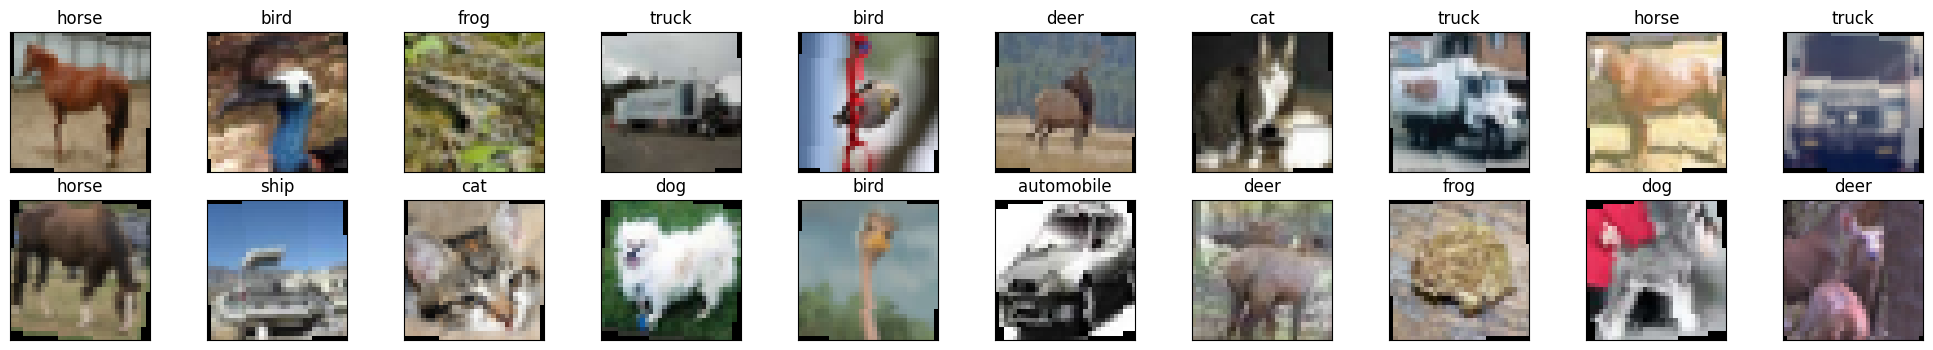

In [5]:
# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

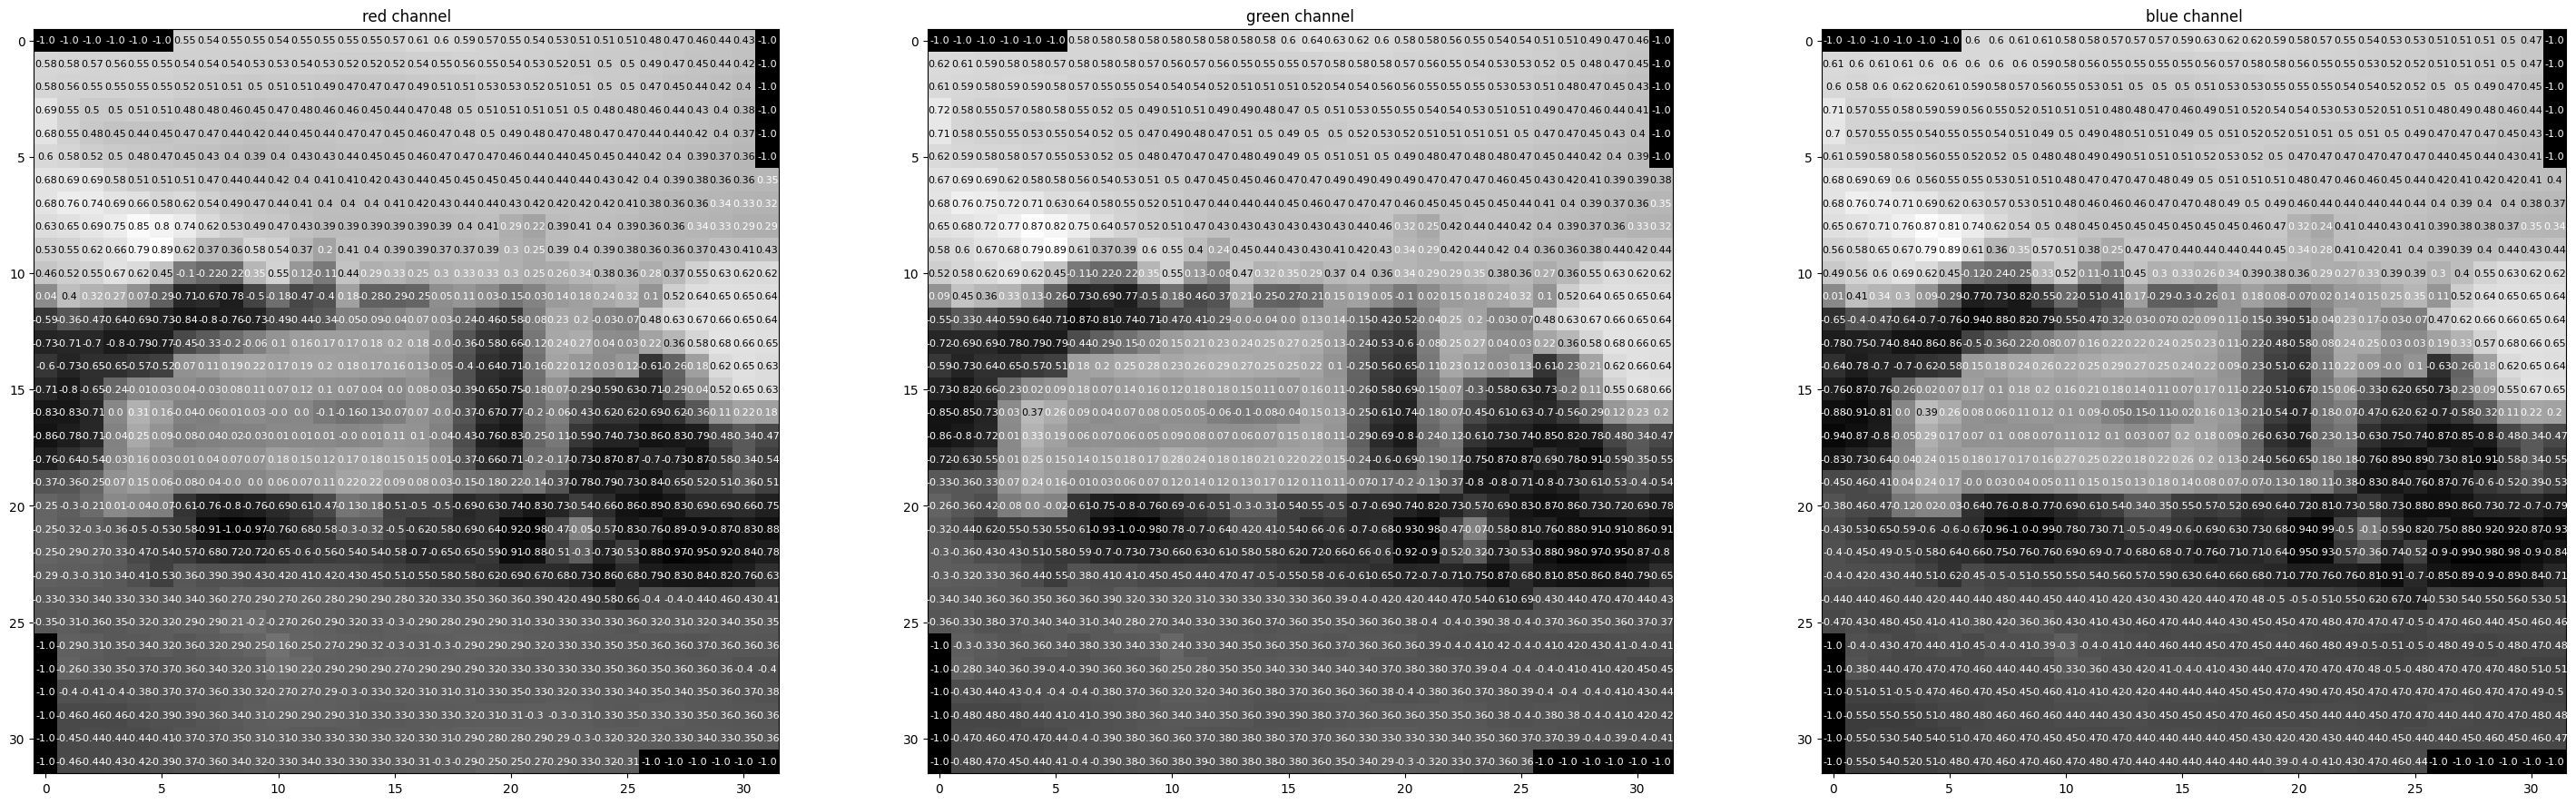

In [6]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

### Step 3: Define the CNN architecture 🧠
The more convolutional layers you include, **the more complex patterns in color and shape a model can detect.**

In [7]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        
        # Convolutional layers
                            #Init_channels, channels, kernel_size, padding) 
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        # Pooling layers
        self.pool = nn.MaxPool2d(2,2)
        
        # FC layers
        # Linear layer (64x4x4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        
        # Linear Layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.pool(F.elu(self.conv3(x)))
        
        # Flatten the image
        x = x.view(-1, 64*4*4)
        x = self.dropout(x)
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNNNet()
print(model)

# Move tensors to GPU is CUDA is available
if train_on_gpu:
    model.cuda()

CNNNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Step 4: Specify Loss function and optimizer

In [8]:
# Specify the Loss function
criterion = nn.CrossEntropyLoss()

# Specify the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Step 5: Train the network
If the validation loss ever increases it means overfitting

In [9]:
# Number of epochs to train the model
n_epochs = 25 

# Keep track of loss and accuracy for each epoch
train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

# Initialize validation loss to infinity
valid_loss_min = np.Inf 

# Loop through epochs
for epoch in range(1, n_epochs+1):

    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Keep track of training and validation accuracy
    train_acc = 0
    valid_acc = 0
    
    ###################
    # Train the model #
    ###################
    
    model.train()
    
    for data, target in train_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item()*data.size(0)
        # Update training accuracy
        _, pred = torch.max(output, 1)
        train_acc += torch.sum(pred == target.data)
        
    ######################
    # Validate the model #
    ######################
    
    model.eval()
    
    for data, target in valid_loader:
        # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # Calculate the batch loss
        loss = criterion(output, target)
        # Update average validation loss 
        valid_loss += loss.item()*data.size(0)
        # Update validation accuracy
        _, pred = torch.max(output, 1)
        valid_acc += torch.sum(pred == target.data)
    
    # Calculate average losses and accuracies
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_acc = train_acc/len(train_loader.dataset)
    valid_acc = valid_acc/len(valid_loader.dataset)
    
    # Append current epoch's loss and accuracy to lists for later plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accs.append(train_acc)
    valid_accs.append(valid_acc)
    
    # Print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    print('Epoch: {} \tTraining Accuracy: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_acc, valid_acc))
    
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
        valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.516344 	Validation Loss: 0.315244
Epoch: 1 	Training Accuracy: 0.256180 	Validation Accuracy: 0.087400
Validation loss decreased (inf --> 0.315244). Saving model ...
Epoch: 2 	Training Loss: 1.207070 	Validation Loss: 0.274570
Epoch: 2 	Training Accuracy: 0.364100 	Validation Accuracy: 0.102640
Validation loss decreased (0.315244 --> 0.274570). Saving model ...
Epoch: 3 	Training Loss: 1.088948 	Validation Loss: 0.252155
Epoch: 3 	Training Accuracy: 0.407080 	Validation Accuracy: 0.111220
Validation loss decreased (0.274570 --> 0.252155). Saving model ...
Epoch: 4 	Training Loss: 1.014653 	Validation Loss: 0.239655
Epoch: 4 	Training Accuracy: 0.437420 	Validation Accuracy: 0.115080
Validation loss decreased (0.252155 --> 0.239655). Saving model ...
Epoch: 5 	Training Loss: 0.956682 	Validation Loss: 0.221777
Epoch: 5 	Training Accuracy: 0.459980 	Validation Accuracy: 0.122060
Validation loss decreased (0.239655 --> 0.221777). Saving model ...
Epoch: 6 	Train

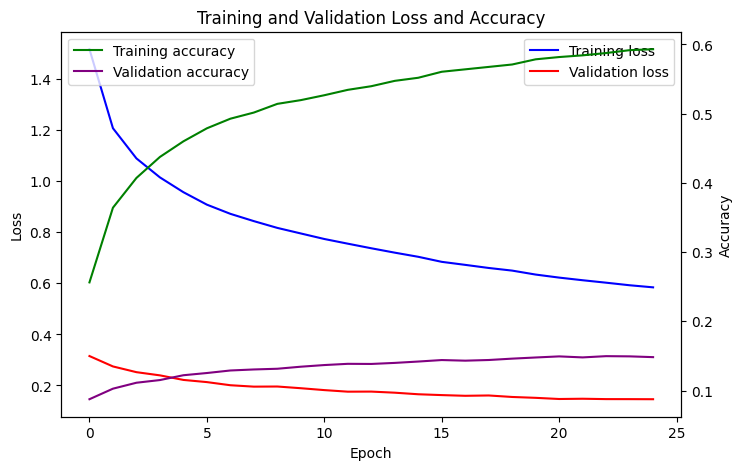

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(train_losses, color='blue', label='Training loss')
ax.plot(valid_losses, color='red', label='Validation loss')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')

ax2 = ax.twinx()
ax2.plot(train_accs, color='green', label='Training accuracy')
ax2.plot(valid_accs, color='purple', label='Validation accuracy')
ax2.legend()
ax2.set_ylabel('Accuracy')

plt.title('Training and Validation Loss and Accuracy')
plt.show()

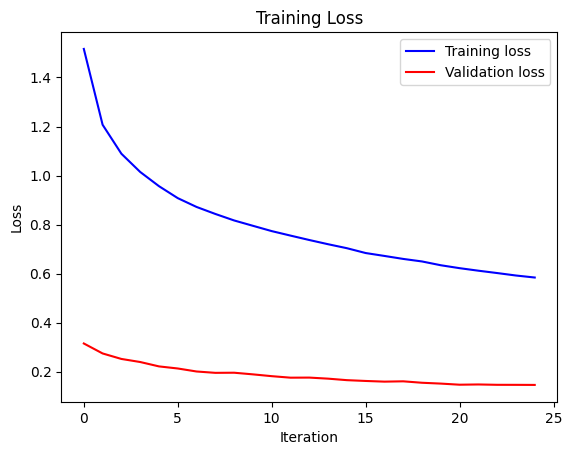

In [11]:
# plotear la pérdida de entrenamiento y validación
plt.plot(train_losses, color='blue', label='Training loss')
plt.plot(valid_losses, color='red', label='Validation loss')
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

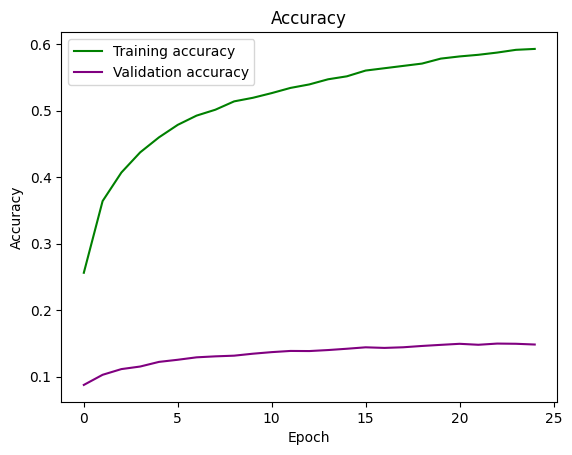

In [12]:
plt.plot(train_accs, color='green', label='Training accuracy')
plt.plot(valid_accs, color='purple', label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [13]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

In [15]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.728794

Test Accuracy of airplane: 68% (687/1000)
Test Accuracy of automobile: 79% (794/1000)
Test Accuracy of  bird: 71% (710/1000)
Test Accuracy of   cat: 48% (483/1000)
Test Accuracy of  deer: 73% (738/1000)
Test Accuracy of   dog: 71% (719/1000)
Test Accuracy of  frog: 79% (798/1000)
Test Accuracy of horse: 76% (766/1000)
Test Accuracy of  ship: 88% (888/1000)
Test Accuracy of truck: 83% (833/1000)

Test Accuracy (Overall): 74% (7416/10000)
